In [44]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### ***The following cell aims to apply my GPU to train the model, modify the value of use_GPU as False if not avaliable.***

In [46]:
use_GPU = True
if torch.cuda.is_available() and use_GPU:
    device = torch.device("cuda")  # Use GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [47]:
file_path = '2013-2015.txt' 
data = pd.read_csv(
    '2013-2015.txt',
    sep=r"\s+",
    header=None,
    names=["Date", "Time", "Open", "Close"],
    dtype={"Date": str, "Time": str},  # Ensure 'Date' and 'Time' are read as strings
)


data['Date'] = pd.to_datetime(data['Date'])

full_date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max())

data['Date'] = pd.to_datetime(data['Date'])


In [48]:
daily_data = data.groupby('Date').agg({
    'Open': 'mean',
    'Close': 'mean'
}).reset_index()

daily_data['Value'] = daily_data[['Open', 'Close']].mean(axis=1)

daily_data = daily_data[['Date', 'Value']]

scaler = MinMaxScaler()
daily_data['Scaled_Value'] = scaler.fit_transform(daily_data[['Value']])

In [49]:
def create_daily_sequences(data, n_days, m_days):
    x, y = [], []
    for i in range(len(data) - n_days - m_days + 1):
        x.append(data[i:i + n_days]) 
        y.append(data[i + n_days:i + n_days + m_days]) 
    return np.array(x), np.array(y)

#### ***In the following cell, modify the N (use N data of previous N days) and M (to predict data of next N days).***

In [51]:
N, M = 30, 3
x, y = create_daily_sequences(daily_data['Scaled_Value'].values, N, M)

In [52]:
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BasicRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 64
num_layers = 2
output_size = M

model = BasicRNN(input_size, hidden_size, num_layers, output_size)

In [53]:
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(x_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


if use_GPU:
    model = model.to(device)
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) 


In [54]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### ***In following cell, modify the value of num_epochs to set how many epochs will be implemented.***

In [56]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train() 
    total_loss = 0
    for batch_x, batch_y in train_loader:
        if use_GPU:batch_x, batch_y = batch_x.to(device), batch_y.to(device) 
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/50], Loss: 0.0686
Epoch [2/50], Loss: 0.0252
Epoch [3/50], Loss: 0.0192
Epoch [4/50], Loss: 0.0099
Epoch [5/50], Loss: 0.0052
Epoch [6/50], Loss: 0.0037
Epoch [7/50], Loss: 0.0028
Epoch [8/50], Loss: 0.0028
Epoch [9/50], Loss: 0.0024
Epoch [10/50], Loss: 0.0021
Epoch [11/50], Loss: 0.0027
Epoch [12/50], Loss: 0.0021
Epoch [13/50], Loss: 0.0023
Epoch [14/50], Loss: 0.0023
Epoch [15/50], Loss: 0.0022
Epoch [16/50], Loss: 0.0019
Epoch [17/50], Loss: 0.0019
Epoch [18/50], Loss: 0.0021
Epoch [19/50], Loss: 0.0019
Epoch [20/50], Loss: 0.0021
Epoch [21/50], Loss: 0.0021
Epoch [22/50], Loss: 0.0022
Epoch [23/50], Loss: 0.0021
Epoch [24/50], Loss: 0.0018
Epoch [25/50], Loss: 0.0017
Epoch [26/50], Loss: 0.0018
Epoch [27/50], Loss: 0.0019
Epoch [28/50], Loss: 0.0019
Epoch [29/50], Loss: 0.0016
Epoch [30/50], Loss: 0.0020
Epoch [31/50], Loss: 0.0016
Epoch [32/50], Loss: 0.0015
Epoch [33/50], Loss: 0.0016
Epoch [34/50], Loss: 0.0021
Epoch [35/50], Loss: 0.0034
Epoch [36/50], Loss: 0.0021
E

In [57]:
model.eval()
test_loss = 0
predictions = []
ground_truth = []
with torch.no_grad(): 
    for batch_x, batch_y in test_loader:
        if use_GPU:batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        predictions.extend(outputs.cpu().numpy().flatten())
        ground_truth.extend(batch_y.cpu().numpy().flatten())
avg_test_loss = test_loss / len(test_loader)

predictions = np.array(predictions)
ground_truth = np.array(ground_truth)
original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
original_ground_truth = scaler.inverse_transform(ground_truth.reshape(-1, 1)).flatten()

mae = np.mean(np.abs(original_predictions - original_ground_truth))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = np.mean((original_predictions - original_ground_truth) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")

mape = np.mean(np.abs((original_predictions - original_ground_truth) / original_ground_truth)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

from sklearn.metrics import r2_score
r2 = r2_score(original_ground_truth, original_predictions)
print(f"R^2 Score: {r2:.2f}")


Mean Absolute Error (MAE): 35.53
Mean Squared Error (MSE): 2414.60
Mean Absolute Percentage Error (MAPE): 1.46%
R^2 Score: 0.97


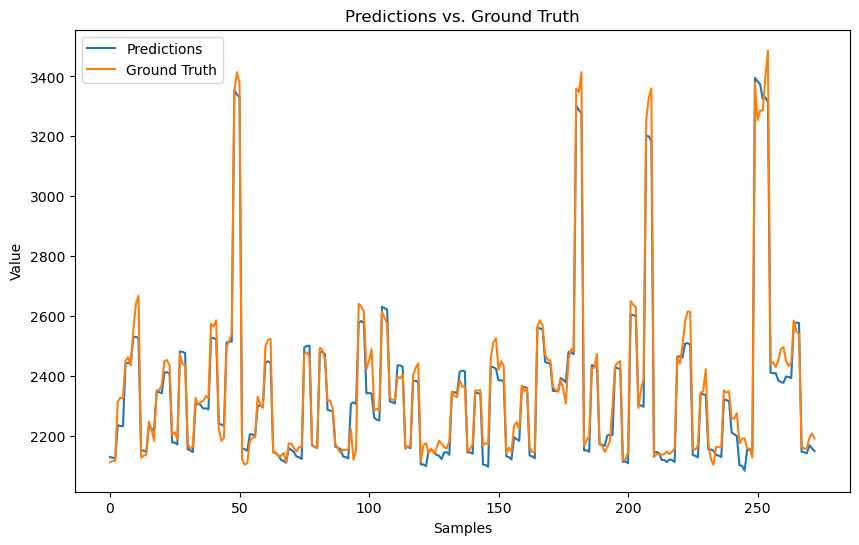

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(original_predictions, label="Predictions")
plt.plot(original_ground_truth, label="Ground Truth")
plt.legend()
plt.title("Predictions vs. Ground Truth")
plt.xlabel("Samples")
plt.ylabel("Value")
plt.show()


In [59]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output 'm' values (e.g., 3)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1  
hidden_size = 64 
num_layers = 1  
output_size = M
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

if use_GPU:
    model = model.to(device)
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) 


In [60]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader: 
        if use_GPU:batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 0.0621
Epoch [2/50], Loss: 0.0263
Epoch [3/50], Loss: 0.0245
Epoch [4/50], Loss: 0.0201
Epoch [5/50], Loss: 0.0154
Epoch [6/50], Loss: 0.0079
Epoch [7/50], Loss: 0.0062
Epoch [8/50], Loss: 0.0067
Epoch [9/50], Loss: 0.0060
Epoch [10/50], Loss: 0.0046
Epoch [11/50], Loss: 0.0042
Epoch [12/50], Loss: 0.0043
Epoch [13/50], Loss: 0.0049
Epoch [14/50], Loss: 0.0040
Epoch [15/50], Loss: 0.0035
Epoch [16/50], Loss: 0.0035
Epoch [17/50], Loss: 0.0037
Epoch [18/50], Loss: 0.0032
Epoch [19/50], Loss: 0.0029
Epoch [20/50], Loss: 0.0032
Epoch [21/50], Loss: 0.0026
Epoch [22/50], Loss: 0.0027
Epoch [23/50], Loss: 0.0024
Epoch [24/50], Loss: 0.0027
Epoch [25/50], Loss: 0.0025
Epoch [26/50], Loss: 0.0021
Epoch [27/50], Loss: 0.0021
Epoch [28/50], Loss: 0.0024
Epoch [29/50], Loss: 0.0021
Epoch [30/50], Loss: 0.0021
Epoch [31/50], Loss: 0.0022
Epoch [32/50], Loss: 0.0026
Epoch [33/50], Loss: 0.0023
Epoch [34/50], Loss: 0.0019
Epoch [35/50], Loss: 0.0019
Epoch [36/50], Loss: 0.0019
E

In [61]:
model.eval()
test_loss = 0
predictions = []
ground_truth = []
with torch.no_grad(): 
    for batch_x, batch_y in test_loader:
        if use_GPU:batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        predictions.extend(outputs.cpu().numpy().flatten())
        ground_truth.extend(batch_y.cpu().numpy().flatten())
avg_test_loss = test_loss / len(test_loader)

predictions = np.array(predictions)
ground_truth = np.array(ground_truth)
original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
original_ground_truth = scaler.inverse_transform(ground_truth.reshape(-1, 1)).flatten()

mae = np.mean(np.abs(original_predictions - original_ground_truth))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = np.mean((original_predictions - original_ground_truth) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")

mape = np.mean(np.abs((original_predictions - original_ground_truth) / original_ground_truth)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

r2 = r2_score(original_ground_truth, original_predictions)
print(f"R^2 Score: {r2:.2f}")


Mean Absolute Error (MAE): 36.22
Mean Squared Error (MSE): 2383.57
Mean Absolute Percentage Error (MAPE): 1.50%
R^2 Score: 0.97


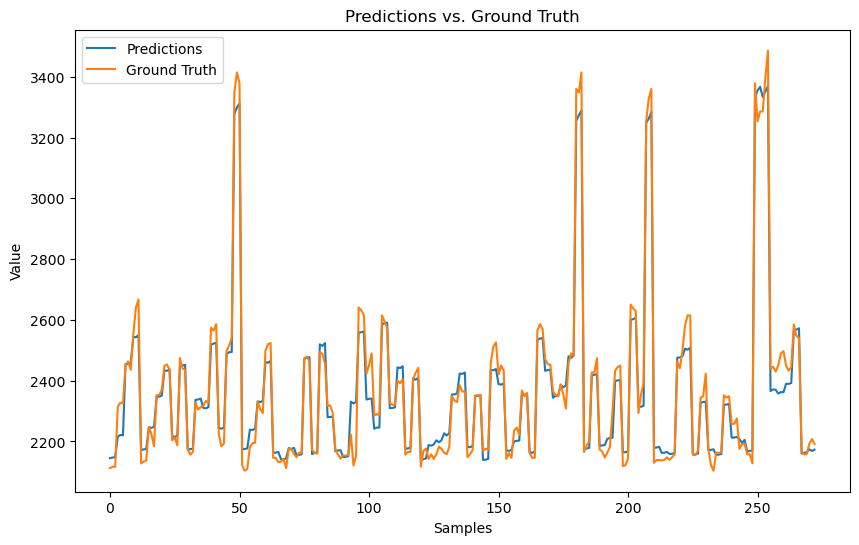

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(original_predictions, label="Predictions")
plt.plot(original_ground_truth, label="Ground Truth")
plt.legend()
plt.title("Predictions vs. Ground Truth")
plt.xlabel("Samples")
plt.ylabel("Value")
plt.show()

In [63]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1 
hidden_size = 64 
num_layers = 1 
output_size = M 
model = GRUModel(input_size, hidden_size, num_layers, output_size)

if use_GPU:
    model = model.to(device)
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) 


In [64]:
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader: 
        if use_GPU:batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 0.0328
Epoch [2/50], Loss: 0.0259
Epoch [3/50], Loss: 0.0207
Epoch [4/50], Loss: 0.0169
Epoch [5/50], Loss: 0.0098
Epoch [6/50], Loss: 0.0043
Epoch [7/50], Loss: 0.0037
Epoch [8/50], Loss: 0.0032
Epoch [9/50], Loss: 0.0028
Epoch [10/50], Loss: 0.0025
Epoch [11/50], Loss: 0.0023
Epoch [12/50], Loss: 0.0022
Epoch [13/50], Loss: 0.0022
Epoch [14/50], Loss: 0.0020
Epoch [15/50], Loss: 0.0020
Epoch [16/50], Loss: 0.0021
Epoch [17/50], Loss: 0.0018
Epoch [18/50], Loss: 0.0019
Epoch [19/50], Loss: 0.0019
Epoch [20/50], Loss: 0.0017
Epoch [21/50], Loss: 0.0017
Epoch [22/50], Loss: 0.0018
Epoch [23/50], Loss: 0.0016
Epoch [24/50], Loss: 0.0016
Epoch [25/50], Loss: 0.0016
Epoch [26/50], Loss: 0.0017
Epoch [27/50], Loss: 0.0015
Epoch [28/50], Loss: 0.0016
Epoch [29/50], Loss: 0.0015
Epoch [30/50], Loss: 0.0016
Epoch [31/50], Loss: 0.0016
Epoch [32/50], Loss: 0.0015
Epoch [33/50], Loss: 0.0015
Epoch [34/50], Loss: 0.0015
Epoch [35/50], Loss: 0.0014
Epoch [36/50], Loss: 0.0014
E

In [65]:
model.eval()
test_loss = 0
predictions = []
ground_truth = []
with torch.no_grad(): 
    for batch_x, batch_y in test_loader:
        if use_GPU:batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        predictions.extend(outputs.cpu().numpy().flatten())
        ground_truth.extend(batch_y.cpu().numpy().flatten())
avg_test_loss = test_loss / len(test_loader)

predictions = np.array(predictions)
ground_truth = np.array(ground_truth)
original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
original_ground_truth = scaler.inverse_transform(ground_truth.reshape(-1, 1)).flatten()

mae = np.mean(np.abs(original_predictions - original_ground_truth))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = np.mean((original_predictions - original_ground_truth) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")

mape = np.mean(np.abs((original_predictions - original_ground_truth) / original_ground_truth)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

r2 = r2_score(original_ground_truth, original_predictions)
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 31.28
Mean Squared Error (MSE): 2116.74
Mean Absolute Percentage Error (MAPE): 1.30%
R^2 Score: 0.97


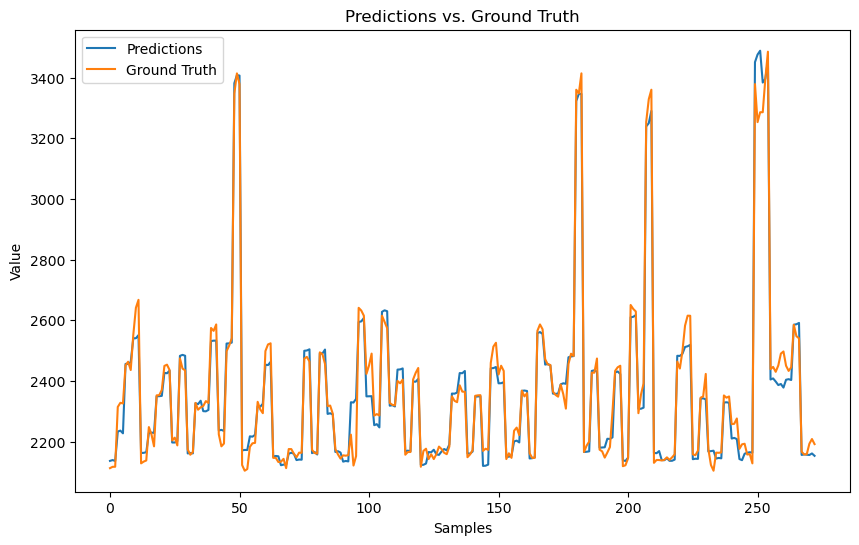

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(original_predictions, label="Predictions")
plt.plot(original_ground_truth, label="Ground Truth")
plt.legend()
plt.title("Predictions vs. Ground Truth")
plt.xlabel("Samples")
plt.ylabel("Value")
plt.show()